# 3.2 - Wavelet-Transformation

<img style="float: right; margin:5px 0px 0px 10px" src="img/2-Titel.png" width="400">
Die Wavelet-Transformation kann als Verbesserung der Kurzzeit-Fourier-Transformation (STFT) angesehen werden. Als Wavelet-Transformation wird eine Familie von linearen Zeit-Frequenz-Transformationen in der Mathematik und den Ingenieurwissenschaften bezeichnet. Mit dem Begriff Wavelet wird in der Mathematik eine Gruppe von Funktionen mit wellenartigem Charakter bezeichnet. Wavelets beschreiben die Funktionsbasis einer kontinuierlichen oder diskreten Wavelet-Transformation. Im Gegensatz zu den Sinus- und Kosinus-Funktionen der Fourier-Transformation besitzen die meistverwendeten Wavelets nicht nur Lokalität im Frequenzspektrum, sondern auch im Zeitbereich. Dabei ist „Lokalität“ im Sinne kleiner Streuung zu verstehen.  

## Inhalt  
<table style="width:256px; border: 1px solid black; display: inline-block">
    <tr>
        <td  style="text-align:right" width=64px><img src="img/1.jpg" style="float:left"></td>
        <td style="text-align:left" width=256px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#1'>
                1. Unzulänglichkeiten der STFT
            </a>
        </td>
    </tr>  
    <tr>
        <td style="text-align:right"><img src="img/2.jpg" style="float:left"></td>
        <td style="text-align:left" width=128px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#2'>
                2. Wavelet-Transformation
            </a>
        </td>
    </tr>
    <tr>
        <td style="text-align:right"><img src="img/3.jpg" style="float:left"></td>
        <td style="text-align:left" width=128px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#3'>
                3. Anwendungsbeispiele
            </a>
        </td>
    </tr>
</table>

----

<a id='1'></a>
<div>
    <img src="img/1.jpg" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        1. Unzulänglichkeiten der STFT 
    </h2>
</div>

Schauen wir nochmal das Beispiel der STFT in 3.1 und versuchen verschiedene Auflösungen (Zeitfensterlängen):

In [1]:
# Externe Module importieren
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy import fftpack, signal, misc
import pywt

In [2]:
# Initialisierung der Variablen
fs_Hz = 200                            # Abtrastfrequenz
T_s = 12                               # Zeitdauer
L = fs_Hz*T_s                          # Länge des Signals
N = int(2**(np.floor(np.log2(L))+1))   # Länge von FFT
t_s = np.linspace(0, T_s, L)           # Zeitbereich
t4_s = np.linspace(0, T_s/4, L//4)     # Viertelzeitbereich
f_Hz = np.linspace(0, fs_Hz/2, N//2)   # Frequenzbereich

# Signale mit unterschiedlichen Zeitreihen
seg1 = 2 * np.sin(10*np.pi*(t4_s))
seg2 = 10 * np.sin(20*np.pi*t4_s)
seg3 = 5 * np.sin(35*np.pi*t4_s)
seg4 = 7 * np.sin(5*np.pi*t4_s)
s1 = np.array([seg1, seg2, seg3, seg4]).flatten()
s2 = np.array([seg3, seg4, seg2, seg1]).flatten()
s3 = np.array([seg2, seg1, seg4, seg3]).flatten()

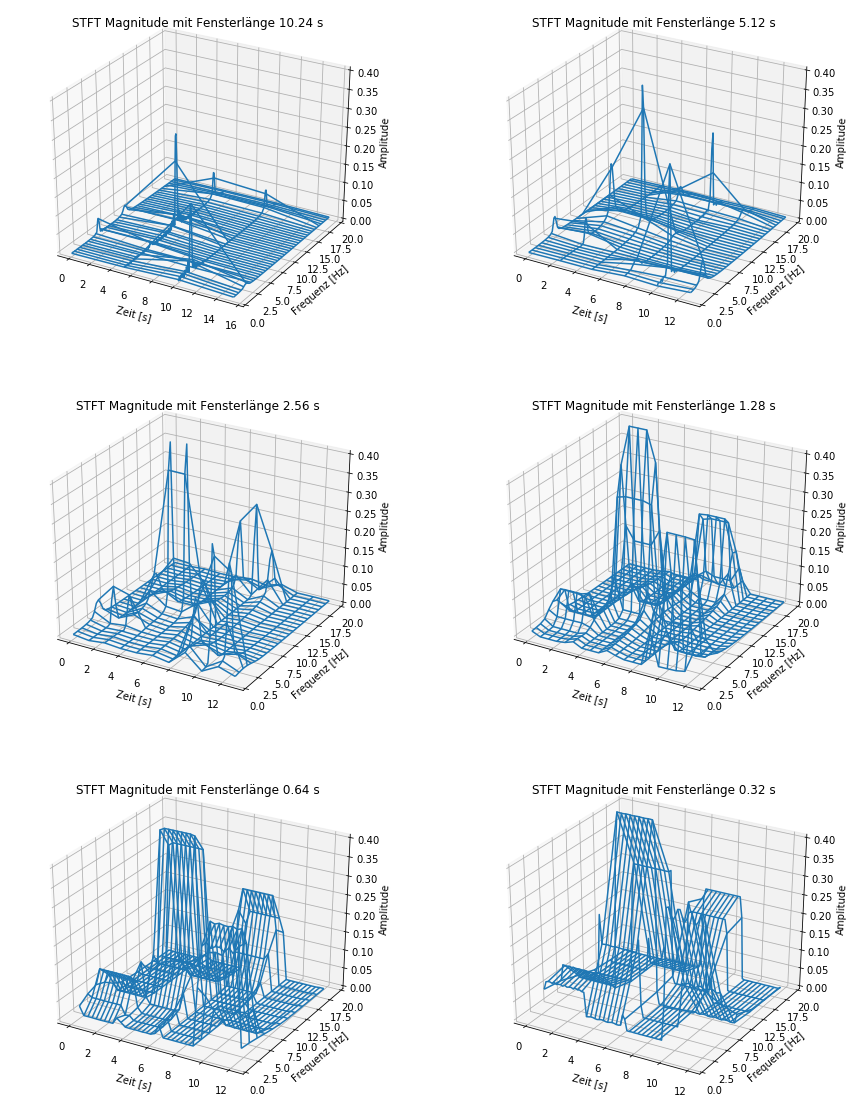

In [3]:
# Spektral durch STFT mit verschiedenen Fensterlängen
s = s1/np.max(s1)
fig = plt.figure()
fig.set_size_inches(15, 20)

for i in range(1, 7):
    
    windowLength = N // (2**(i))
    TWindow_s = windowLength/fs_Hz
    f, t, Zxx = signal.stft(s, fs_Hz, nperseg=windowLength)     
    fLimit = (f>0) & (f<20)             
    f = f[fLimit]                        
    Zxx = Zxx[fLimit]
    
    ax = fig.add_subplot(3,2,i, projection='3d')
    ax.set_title('STFT Magnitude mit Fensterlänge %.2f s' %TWindow_s)
    ax.set_xlabel('Zeit [s]') 
    ax.set_ylabel('Frequenz [Hz]')  
    ax.set_zlabel('Amplitude')  
    ax.set_ylim(0, 20)
    ax.set_zlim(0, 0.4)
#   ax.plot_surface(t[None, :], f[:, None], abs(Zxx), cmap=cm.coolwarm) 
    ax.plot_wireframe(t[None, :], f[:, None], abs(Zxx))     
          
plt.show()

Wir haben anhand des Beispiels gesehen, dass es im Vergleich zu einer spektrografischen Darstellung mit mittlerer Zeitfensterlänge (1.28 s) durch Verlängerung bzw. Verkürzung des Zeitfensters möglich ist, mehr spektrale Details (Schmalbandspektrogramm) bzw. mehr zeitliche Details (Breitbandspektrogramm) zu gewinnen. Am besten wäre es, man könnte beide Vorteile in einem Spektrogramm vereinen, und zwar möglichst unter Berücksichtigung der folgenden Gesichtspunkte:
- Bei niedrigen Frequenzen wünscht man sich eine gute Frequenzauflösung.  
- Die höheren Frequenzen enthalten offensichtlich weniger relevante spektrale Information, sodass ihre spektrale Auflösung durch die STFT zu genau erscheint. Man würde sich deshalb wünschen, dass in diesem Bereich des Spektrogramms die spektrale Auflösung verringert werden könnte, damit man zugleich von einer deutlich verbesserten zeitlichen Auflösung profitiert.

Überträgt man diese Wünsche auf das Raster eines Spektrogramms, wie es dargestellt wurde, sollte es so modifiziert werden, dass die dargestellten Rechtecke bei tiefen Frequenzen möglichst flach (und damit breit), bei hohen Frequenzen möglichst schmal (und damit hoch) sein sollten. Das ist kein Widerspruch zur Unschärferelation, die nur einen einheitlichen Flächeninhalt der Rechtecke fordert. Trotzdem sind die Wünsche durch die STFT nicht erfüllbar, weil sie nur eine einheitliche Rasterung der Zeit-Frequenz-Ebene zulasst. Unabhängig von deren Frequenz besitzt die zum  Ausschneiden benutzte Fensterfunktion $ h(t) $ stets eine feste Länge, was dazu führt, dass das Spektrum der Aufbaufunktionen auch stets eine konstante absolute Bandbreite hat. Daher müssen wir nach Alternativen zur STFT suchen, um die Wünsche zu erfüllen. Es gibt mehrere Möglichkeiten, die Analyse von Signalen über der Zeit-Frequenz-Ebene flexibler zu gestalten, beispielsweise Modifikationen am Fourier-Integral, Wavelet-Transformation und Filterbank-Analyse. Hier konzentrieren wir uns auf Wavelet-Transformation.

----

<a id='2'></a>
<div>
    <img src="img/2.jpg" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        2. Wavelet-Transformation 
    </h2>
</div>

STFT dient dazu, das Signal zu fenstern und FFT in Segmenten durchzuführen. Anders als STFT, die Wavelet-Transformation ändert direkt die Funktionsbasis der Transformation: Die unendliche trigonometrische Funktionsbasis wird durch die endliche abgeschwächte Wavelet-Basis ersetzt, die nicht nur Frequenz erhalten werden, sondern auch die Zeit lokalisieren kann. Daher befassen wir uns mit der sogenannten Wavelet-Transformation, in deren Transformationsintegral Aufbaufunktionen verwendet werden sollen, die möglichst freizügig wählbar sind. Solche Aufbaufunktionen lauten damit:
\begin{equation}
\psi _{a,t}(\tau )=\frac{1}{\sqrt{a}}\psi (\frac{\tau -t}{a}) 
\end{equation} 
Nachdem die Aufbaufunktionen definiert sind, ist die Angabe der Hintransformationsgleichung der Wavelet-Transformation als Skalarprodukt sofort möglich: 
\begin{equation}
S(a,t)=\left \langle s,\psi _{a,t}\right \rangle=\frac{1}{\sqrt{a}}\int_{-\infty }^{\infty }s(\tau )\psi^{*} (\frac{\tau -t}{a})d\tau 
\end{equation} 
Aus der Formel ist ersichtlich, dass Ähnlich wie die STFT die Wavelet-Transformation auch eine Bildfunktion liefert, die von zwei Variablen abhängig ist: Skala $a$ und Translation $t$. Die Skala $a$ steuert die Expansion und Kontraktion der Wavelet-Funktion, und der Translationsbetrag $t$ steuert die Translation der Wavelet-Funktion. Die Skala entspricht der Frequenz (umgekehrt proportional) und der Betrag der Translation entspricht der Zeit. Laut Definition bewirkt Vergrößerung von $a$ eine Verbreiterung des Wavelets. Wenn also das Mutter-Wavelet eine bestimmte Spektralkomponente mit der Frequenz $\omega_{m}$ besitzt, verringert sich diese bei $a$-facher Dehnung des Wavelets auf $\omega_{m}/a$, und das Wavelet passt nun besser zu niederfrequenteren Signalbestandteilen. Für die grafische Darstellung der Zeit-Frequenz-Ebene bedeutet das, dass man im allgemeinen Fall in "Frequenzrichtung" Zahlenwerte nur für die Skale auftragen kann, und zwar in gegenläufiger Richtung.

Als nächstes verwenden wir das externe Modul [PyWavelets](https://pywavelets.readthedocs.io/en/latest/), um Wavelet-Transformation zu implementieren:

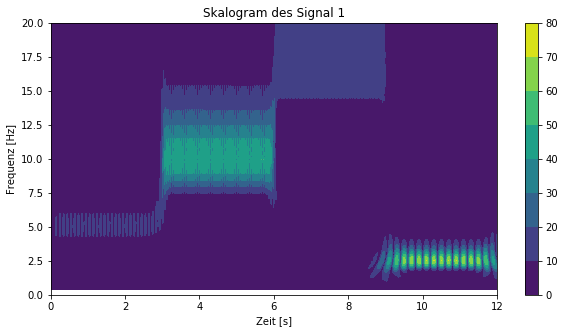

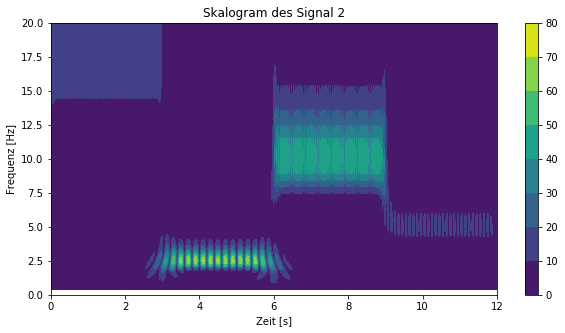

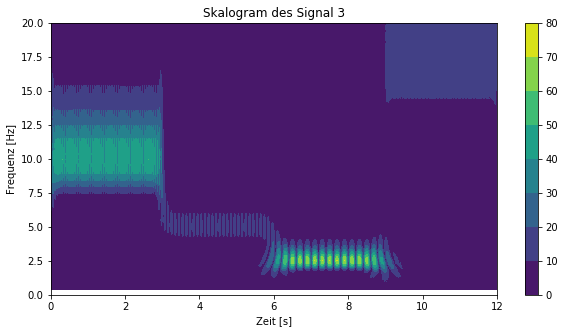

In [4]:
# Wavelet-Transformation
wavename = 'morl' 
totalScales = 512
fc_Hz = pywt.central_frequency(wavename)
scales = 2 * fc_Hz * totalScales / np.arange(totalScales, 1, -1)
i = 0
for s in (s1, s2, s3):   
    i += 1
    cwt_matrix, f_Hz = pywt.cwt(s, scales, wavename, 1/fs_Hz)
    fig = plt.figure()
    fig.set_size_inches(10, 5)
    plt.contourf(t_s, f_Hz, np.abs(cwt_matrix))
    plt.title('Skalogram des Signal %d' %i)
    plt.ylabel('Frequenz [Hz]')
    plt.xlabel('Zeit [s]')
    plt.ylim(0, 20)
    plt.colorbar()
    plt.show()

Es gibt viele Wavelets zur Auswahl, z.B. für kontinuerliche Wavelet-Transformation:

In [5]:
# Wavelets-Type anzeigen
pywt.wavelist(kind='continuous')

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

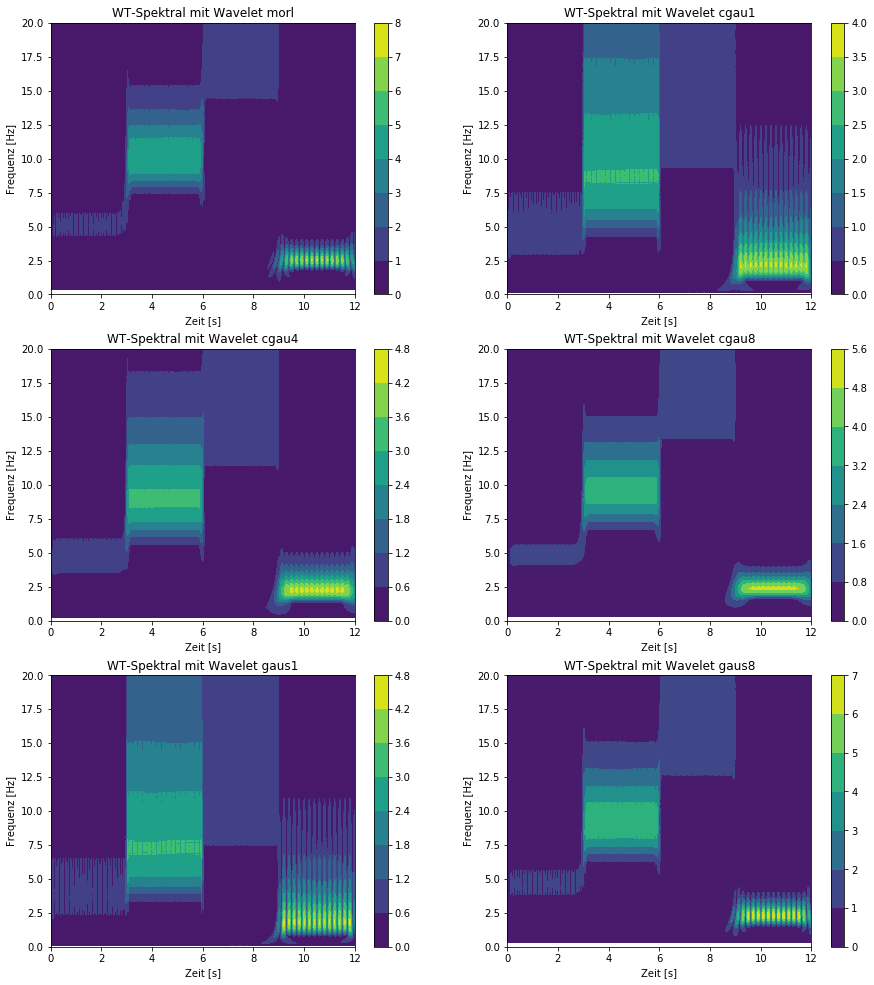

In [6]:
# Wavelet-Transformation mit verschiedenen Wavelets
i = 0
totalScales = 512
fc_Hz = pywt.central_frequency(wavename)
scales = 2 * fc_Hz * totalScales / np.arange(totalScales, 1, -1)
s = s1/np.max(s1)
fig = plt.figure()
fig.set_size_inches(15, 17)
for wavename in ('morl', 'cgau1','cgau4', 'cgau8', 'gaus1', 'gaus8'):   
    cwt_matrix, f_Hz = pywt.cwt(s, scales, wavename, 1/fs_Hz)
    i += 1   
    plt.subplot(3,2,i)
    plt.contourf(t_s, f_Hz, np.abs(cwt_matrix))
    plt.title('WT-Spektral mit Wavelet %s' %wavename)
    plt.ylabel('Frequenz [Hz]')
    plt.xlabel('Zeit [s]')
    plt.ylim(0, 20)
    plt.colorbar()
plt.show()

----

<a id='3'></a>
<div>
    <img src="img/3.jpg" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        3. Anwendungsbeispiele 
    </h2>
</div>

Als Beispiel verwenden wir 2D-discrete Wavelet-Transformation für Bildverarbeitung. Zuerst führen Sie folgende Codes, um  das Package [opencv-python](https://pypi.org/project/opencv-python/) zu installieren:

``` python
pip install opencv-python
```

Dann importieren Sie das Modul cv2, um die Bilder zu laden:

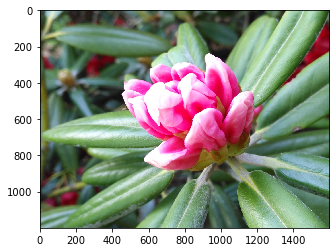

In [7]:
# Bild laden
import cv2
original = cv2.imread('img/2-WT2.jpg')
original = original[:,:,[2,1,0]]   # BGR in RGB konvertieren
plt.imshow(original)

In [8]:
pywt.wavelist(kind='discrete')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

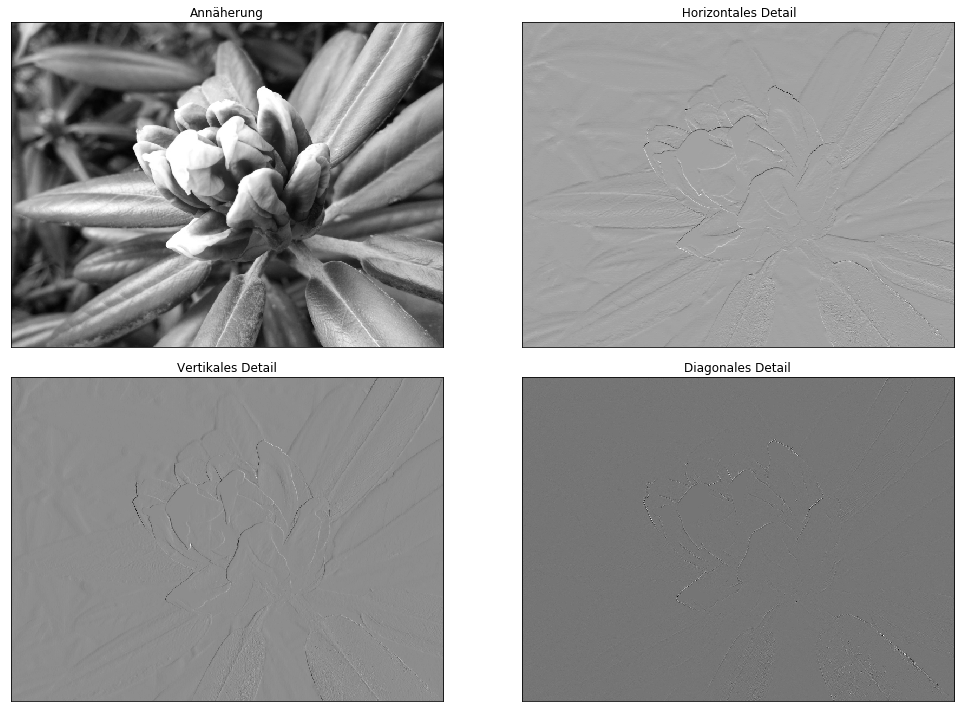

In [9]:
# Wavelet transform of image, and plot approximation and details
img = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY).astype(np.float32)
titles = ['Annäherung', ' Horizontales Detail', 'Vertikales Detail', 'Diagonales Detail']
coeffs2 = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(15, 10))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow(a, cmap=plt.cm.gray)
    ax.set_title(titles[i])
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

----

### References

1. Titelbild aus [Clipartmax](https://www.clipartmax.com/middle/m2i8Z5G6m2K9G6m2_ripples-water-ripple-png/)  
2. [Wavelet-Transformation](https://de.wikipedia.org/wiki/Wavelet-Transformation)
3. Lehrbuch: [Intelligente Signalverarbeitung 1 - Signalanalyse](https://katalog.slub-dresden.de/id/0-1654371521/#detail)  
4. Wavelet-Transformation-Pakete für Python: [pywavelets](https://pywavelets.readthedocs.io/en/latest/)  
5. OpenCV-Pakete für Python: [opencv-python](https://pypi.org/project/opencv-python/)